## Load DAMM

In [1]:
#sys.path.append('/home/campbell/yulee/DAMM/new/code/pro')

import damm as model

## Load h5ad file (expression & size) and zip file via torch.load (spillover expression)

In [3]:
import torch
import numpy as np
import scanpy as sc

cohort = 'eddy'
ss = 10
sa = 'dc'
tr_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/{}/tr_exp.h5ad'.format(cohort, ss, sa))
pretty_printing = np.hstack([tr_exp.var_names, 'size'])

tr_so = torch.load('/home/campbell/yulee/DAMM/new/data/{}/{}k/{}/tr_so.zip'.format(cohort, ss, sa))

nc = 15

## Create an instance of the DAMM class

In [4]:
md = model.DAMM(numOfCluster=nc, h5ad_dset=tr_exp, incCellSize=True, soMat=tr_so, spilloverRate=0.1,  
                initMethod='gmm', noiseModel='student', relaxRule=True, regularizer=10, 
                batchSize=128, learnRate=1e-3, maxEpoch=100)

## DAMM Initialization

In [5]:
init_label, init_center = md.damm_init()

## Fit DAMM

In [ ]:
loss, Theta1 = md.fit()

/home/campbell/yulee/DAMM/new/code/pro/damm.py:228: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  ccmax = torch.combinations(psi).max(1).values


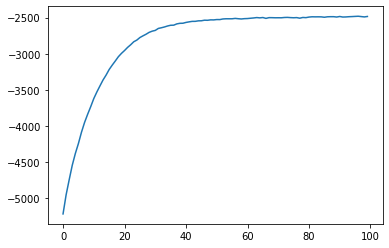

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(pd.DataFrame(loss, columns = ['tot_loss', 'real_lls', 'fake_lls', 'fake_loss'])['tot_loss'])

## DAMM label

In [32]:
cell_label, singlet_label, doublet_label = md.get_labels()
damm_sorted_by_count = pd.Series(singlet_label).value_counts().index

if len(damm_sorted_by_count) != nc:
    damm_sorted_by_count = np.hstack((damm_sorted_by_count, np.setdiff1d(range(nc), damm_sorted_by_count)))
        
## save damm labels
damm_labels = np.zeros(tr_exp.shape[0], dtype=int) + 50
damm_labels[cell_label == 0] = singlet_label

damm_label = np.zeros(tr_exp.shape[0], dtype=int) + 50
for i, val in enumerate(damm_sorted_by_count):
    damm_label[damm_labels == val] = i
damm_label = damm_label.astype(str)
damm_label[damm_label == '50'] = 'doublets'
tr_exp.obs['damm_label'] = damm_label

## save damm centers
damm_centers = np.array(torch.hstack([Theta1['log_mu'], Theta1['log_psi'].reshape(-1,1)]).detach().exp())
damm_centers = damm_centers[damm_sorted_by_count]

## Heatmap

Text(156.0, 0.5, 'Cluster')

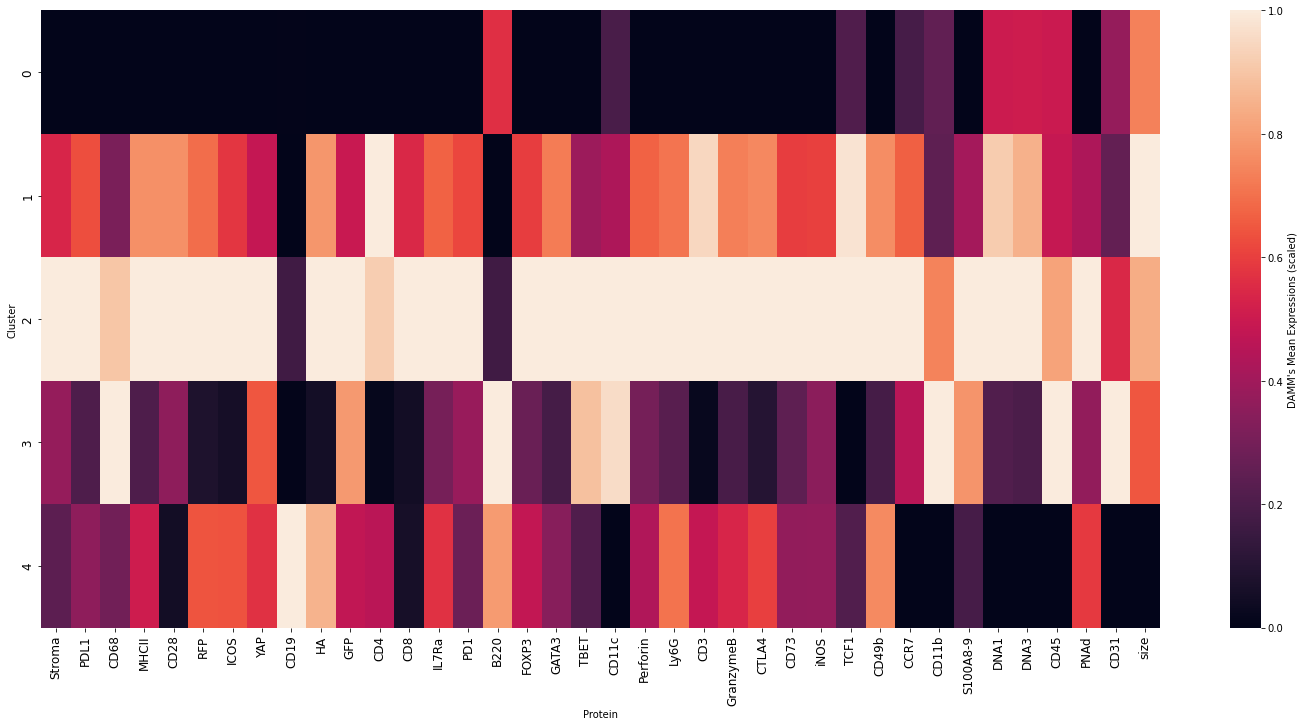

In [36]:
plt.rcParams['figure.figsize'] = [20, 10]
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
s2 = scaler.fit(damm_centers)
s3 = scaler.transform(damm_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'damm_label' as categorical


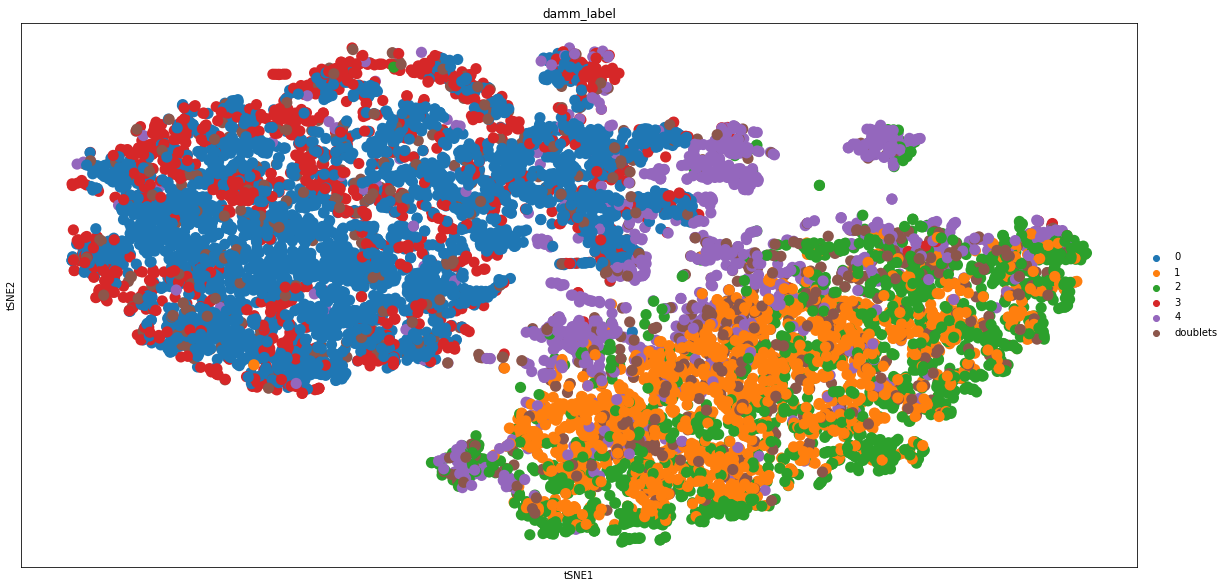

In [37]:
#sc.tl.tsne(tr_exp)
#sc.pl.tsne(tr_exp, color = "damm_label", size = 500)

## Pinch Effect

In [42]:
singlet_set = tr_exp.obs[tr_exp.obs['damm_label'] != 'doublets']
doublet_set = tr_exp.obs[tr_exp.obs['damm_label'] == 'doublets']

df1 = pd.DataFrame(singlet_set['area_convex']/singlet_set['area']).assign(Doublet=0)
df2 = pd.DataFrame(doublet_set['area_convex']/doublet_set['area']).assign(Doublet=1)
df3 = pd.concat([df1, df2])                                # CONCATENATE
df3.columns = ['Ratio', 'Doublet']

In [48]:
import scipy.stats as stats
print("Difference:", 
      np.mean(doublet_set['area_convex']/doublet_set['area']) - 
      np.mean(singlet_set['area_convex']/singlet_set['area']))
stats.ttest_ind(singlet_set['area_convex']/singlet_set['area'], 
                      doublet_set['area_convex']/doublet_set['area'])

Difference: 0.03164480195547448


Ttest_indResult(statistic=-14.78015773157116, pvalue=6.446247901742715e-49)